In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)    # resize numpy output

## Data Preprocessing

In [2]:
import zipfile,kaggle
path = Path('titanic')
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]   # use iloc[0] bc output is df ('PassengerId' is multimodal)

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Convert non-numeric data to categorical data. In pandas, converting to categorical variables creates a list of all unique values in the column and replace each value in the list with a number (a class index).

In [4]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)    # replace na values with 0
    df.fillna(modes, inplace=True)    # replace other nas with modes of respective columns
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)
    
proc_data(df)
proc_data(tst_df)

**Note:** Random forests care about order, not absolute value. So, the `Pclass` field is not considered a categorical variable for the purposes of RF modeling.

In [5]:
cats = ['Sex', 'Embarked']
conts = ['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
dep = 'Survived'

Observing categorical variables by value and by category index:

In [6]:
df.Sex.head(3)

0      male
1    female
2    female
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [7]:
df.Sex.cat.codes.head(3)

0    1
1    0
2    0
dtype: int8

### Splitting the Dataset into Training and Validation Sets

In [8]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
tr_df, val_df = train_test_split(df, test_size=0.25)
tr_df[cats] = tr_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [9]:
def x_y(df):
    x = df[cats+conts].copy()
    y = df[dep] if dep in df else None
    return x, y

x_tr, y_tr = x_y(tr_df)
x_val, y_val = x_y(val_df)

## Binary Splits

Split data into two separate groups by some criteria. Intuitive split is simply to separate the sexes:

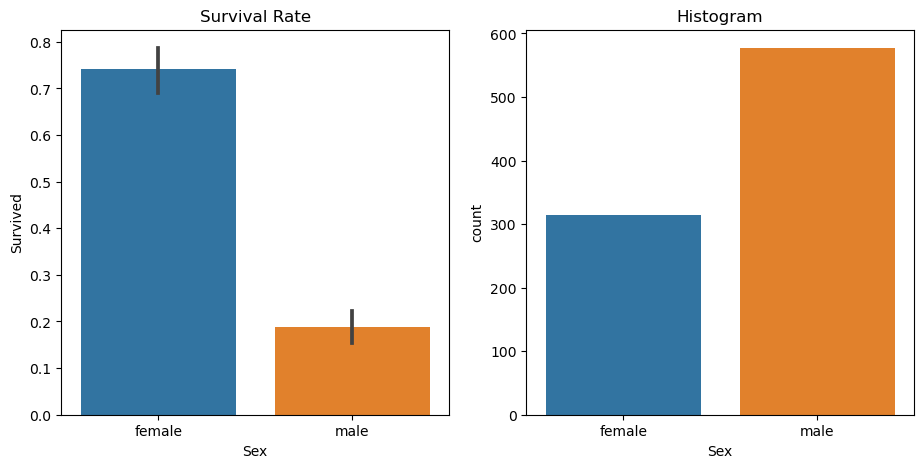

In [10]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(11,5))
sns.barplot(data=df, y=dep, x='Sex', ax=axs[0]).set(title='Survival Rate')
sns.countplot(data=df, x='Sex', ax=axs[1]).set(title='Histogram');

In [11]:
from sklearn.metrics import mean_absolute_error

# predicting based on sex alone (survived if female)
preds = x_val.Sex == 0    # T if female, F if male
mean_absolute_error(y_val, preds)

0.21524663677130046

Splitting on a continuous variable: `LogFare`

<Axes: xlabel='LogFare', ylabel='Density'>

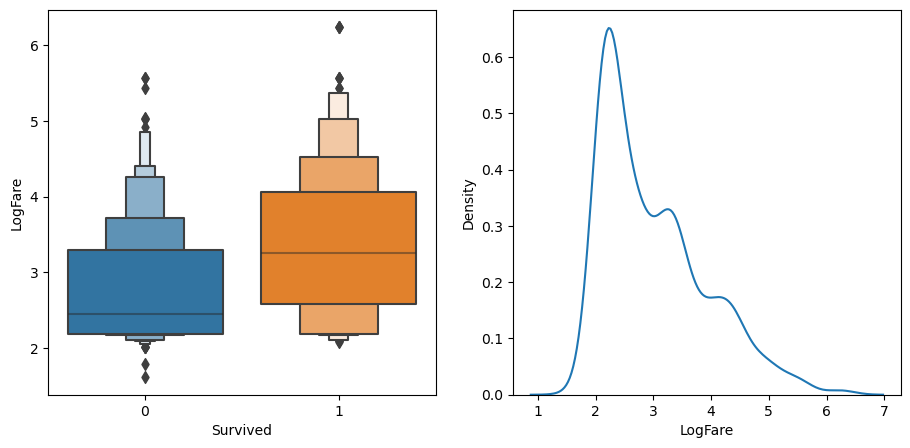

In [12]:
df_fare = tr_df[tr_df.LogFare>0]
fig, axs = plt.subplots(1, 2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y = 'LogFare', ax=axs[0])
sns.kdeplot(data=df_fare, x='LogFare', ax=axs[1])

The mean `LogFare` for passengers who died is around 2.5, while it is around 3.2 for those who survived. MAE for predictions based on `LogFare` mean values (split the difference, 2.85) alone:

In [13]:
preds = x_val.LogFare > 2.85
mean_absolute_error(y_val, preds)

0.31390134529147984

Starting to look at ***Impurity Measures*** - criteria for measuring the similarity of data within a split. Howard motivates these measures with a simple function of standard deviation. The intuition is that higher standard deviation indicates a wider spread of data, and therefore greater dissimilarity. The standard deviation is scaled by the number of rows, since a larger group has a greater impact than a smaller group. If the group has no rows, then we jsut return 0.

Let's look at the split on `Sex` within the training dataset. This dataset has 668 rows. We can partition it between `Male` and `Female` with the `<= 0.5` conditional because we mapped these categories as a boolean:

In [14]:
hmm = x_tr['Sex'] <= 0.5

Then we can "count" the rows for each `Sex` category by summing over the True/False fields of this partition:

In [15]:
hmm.sum(), (~hmm).sum(), (hmm | ~hmm).sum()    # the pipe ('|') operator is '+' for bool dtypes

(229, 439, 668)

Wrapping this into a function with stdev of the partition:

In [16]:
def _side_score(side, y):
    tot = side.sum()
    if tot <= 1: return 0     # zero-out if group is empty
    return y[side].std() * tot

**NOTE:** The stdev is of the dependent variable (y)

Now we can flesh this out to calculate stdev-based impurity measures for different splits on different variables:

In [17]:
def score(col, y, split):
    lhs = col <= split    # 'lhs' is left-hand-side
    return (_side_score(lhs,y) + _side_score(~lhs,y)) / len(y)

Testing this out for `Sex` and `LogFare`:

In [18]:
print(f"Sex: {score(x_tr['Sex'], y_tr, split=2.7):.4f}")
print(f"LogFare: {score(x_tr['LogFare'], y_tr, split=2.7):.4f}")

Sex: 0.4854
LogFare: 0.4718


Neat little UI scale to interact with this impurity measure:

In [19]:
def iscore(nm, split):
    col = x_tr[nm]
    return f'{score(col, y_tr, split):.8f}'

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [20]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

Function for finding the best split based on minimizing this stdev-based score:

In [21]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()     # each unique value of variable
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)]) # score for each unique val
    idx = scores.argmin()           # minimum score across all unique values
    return unq[idx],scores[idx]

min_col(tr_df, "Age")

(6.0, 0.47831671750899085)

Then, we can split on the variable that results in the lowest score:

In [22]:
cols = cats+conts
{o:min_col(tr_df, o) for o in cols}    # dict of variables and minimum scores

{'Sex': (0, 0.4078753098206398),
 'Embarked': (0, 0.478833425731479),
 'Age': (6.0, 0.47831671750899085),
 'SibSp': (4, 0.4783740258817423),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736595),
 'Pclass': (2, 0.4604826188580666)}

So, splitting on `Sex` produces the best possible split - according to this impurity measure.

## Creating a Decision Tree

We can build up a decision tree by repeating binary splits for each subgroup created by the previous binary split. 

First, we'll remove `Sex` because we've already spit on it and create two new datasets for each group of the split:

In [23]:
cols.remove('Sex')        # removed from list of cols
ismale = tr_df.Sex == 1   # partition on sex
males, females = tr_df[ismale], tr_df[~ismale]

Repeating the search for the best binary split on each of these new datasets:

In [24]:
{o:min_col(males, o) for o in cols}

{'Embarked': (0, 0.387558187041091),
 'Age': (6.0, 0.37398283710105873),
 'SibSp': (4, 0.38758642275862637),
 'Parch': (0, 0.3874704821461953),
 'LogFare': (2.803360380906535, 0.38048562317581447),
 'Pclass': (1, 0.3815544200436083)}

In [25]:
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857326),
 'Age': (50.0, 0.4225927658431646),
 'SibSp': (4, 0.42319212059713585),
 'Parch': (3, 0.4193314500446157),
 'LogFare': (4.256321678298823, 0.413505983329114),
 'Pclass': (2, 0.3335388911567602)}

It looks like the best split for `males` is `Age<=6.0` and the best split for `females` is `Pclass<=2`

### Creating a Tree with sklearn

We can scale up this process by using `sklearn`:

In [26]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(x_tr, y_tr);

And we can visualize it with `graphviz` because `sklearn` has some very handy compatabilities with `graphviz`:

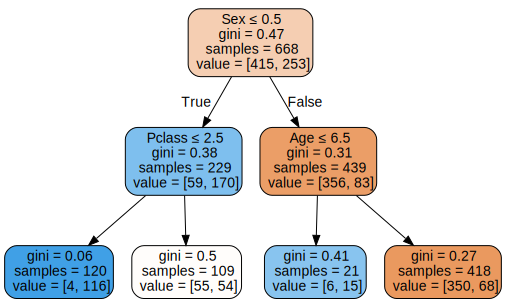

In [27]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(m, x_tr)

This tree is using a different impurity measure than that which we defined in `score`. It uses `Gini` impurity which is defined as:
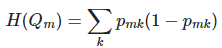
For:
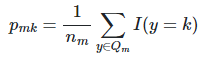
We can replicate `Gini` impurity:

In [28]:
def gini(cond, df):
    act = df.loc[cond, dep]    # classes given condition (e.g. survival statuses for all females)
    return 1 - act.mean()**2 - (1-act).mean()**2

Note that for a binary split with a boolean dependent variable, *p_mk* is equivalent to the mean over the range of elements where the condition `cond` is true. 

In [29]:
gini(tr_df.Sex<=0.5, tr_df), gini(tr_df.Sex>0.5, tr_df)

(0.38252512347209255, 0.3066401689488951)

In [30]:
gini(females.Pclass<=2.5, females), gini(females.Pclass>2.5, females)

(0.06444444444444448, 0.4999579160003367)

### Embiggening the sklearn Tree

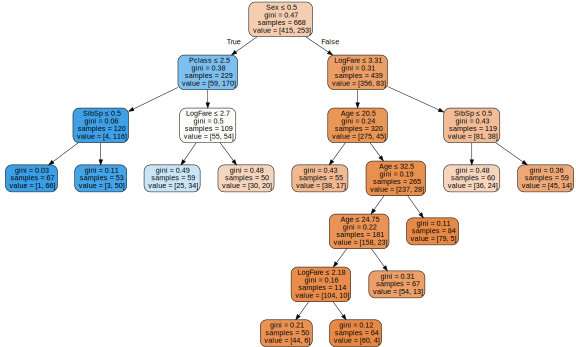

In [31]:
m = DecisionTreeClassifier(min_samples_leaf=50)    # stopping criteria is min number of rows = 50
m.fit(x_tr, y_tr)
draw_tree(m, x_tr, size=8)

In [32]:
mean_absolute_error(y_val, m.predict(x_val))

0.18385650224215247

## Random Forest

### Boostrapping

Bootstrapping creates artificial subsets of observations from the dataset, makes predictions on the subsets, and then combines the predictions across the subsets. Sampling is done randomly and with replacement (so we may have repeated datapoints in a sample). Crucially, each bootstrapped sample must have the *same number of observations* as the original dataset. 

Given *n* observations, we can create *n^n* bootstrap samples and (2*n* - 1) C (*n* - 1) distinct bootstrap samples.

**Note:** On average, a bootstrap sample uses only 2/3 (approximately) of the original observations (because of replacement)

### Bagging

Aka. "Bootstrap Aggregation"

Bagging produces *b* bootstrapped sample from the dataset, makes predictions from the samples, then averages the predictions to produce a final prediction.

The objective is to make each model's predictions in the averaged ensemble to be uncorrelated with each other model. That way, when the predictions are averaged, the average will be equal to the true target value because *the average of uncorrelated random errors converges to zero* **BAM**.

***Bagged Trees*** use decision trees to make their predictions. I.e., classification trees for classification problems and regression trees for regression problems. 

**Caveat:** The samples don't *need* to be bootstrap samples to be considered bagging, sometimes bagging will be done with samples that are smaller than the dataset.

Continuing with J.Howard's notebook, we'll make some bagged trees using random subsets of the dataset:

In [33]:
def get_tree(prop=0.75):
    n = len(y_tr)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(x_tr.iloc[idxs], y_tr.iloc[idxs])

In [34]:
trees = [get_tree() for t in range(100)]

Then we average the predictions across these trees:

In [132]:
all_probs = [t.predict(x_val) for t in trees]
avg_probs = np.where(np.stack(all_probs).mean(0) <= 0.5, 0, 1)   # round to 0 or 1

mean_absolute_error(y_val, avg_probs)

0.18385650224215247

We can compare this with a random forest using sklearn:

In [133]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(x_tr, y_tr);
mean_absolute_error(y_val, rf.predict(x_val))

0.17937219730941703

#### Out-of-Bag (OOB) Errors

Because only 2/3 of all observations are used to train each bagged tree (on average) we can use the observations that are not used to estimate the test error for the tree. These unused observations are called ***Out-of-Bag (OOB) Observations***.

Steps:
1. For each bagged tree, predict the response for each OOB observation.
2. For each observation in the training dataset, average the predictions (regression trees) or select the mode category (classification) to obtain a single prediction.
3. Using the predictions, compute OOB error.

I'm not going to work through an example here, just understand the concept of OOB error

### Variable Importance Measures

If bagged trees happen to be similar, then their predictions will be correlated. With correlated predictions, averaging the predictions won't lead to a reduction in the variance of the estimate. One reason that bagged trees may be similar is if one variable has an overwhelmin effect on the predictions. For example, suppose that `Sex` had an even greater impact on survival rates, like 75% of females survived and only 10% of males. Then we would expect `Sex` to be the first split among a majority of the bagged trees. We can measure the importance of an explanatory variable with ***Variable Importance Measures***

Two approaches:
1. Calculate the mean decrease in accuracy of the OOB predictions *when the variable is excluded from the model*
2. Calculate the mean decrease in node purity due to splits over the variable

Fortunately, `sklearn` decision trees have an attribute that gives us the importance of each variable considered by the decision tree. These importances are calculated via approach 2: 
        
    "The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance."

In [80]:
vims = trees[0].feature_importances_[:, None]
feature_names =  trees[0].feature_names_in_
feature_importances = {}

for name, vim in zip(feature_names, vims):
        feature_importances[name] = vim.item()

feature_importances

{'Sex': 0.5189666631863772,
 'Embarked': 0.012288346465814268,
 'Age': 0.09679619591780457,
 'SibSp': 0.0,
 'Parch': 0.0,
 'LogFare': 0.3185475681173119,
 'Pclass': 0.05340122631269221}

We can see from this method that `Sex` is the most important feature in the model and that `SibSp` and `Parch` were the least important. Indeed, with importance measures of 0, neither of the features were used as splits at all, as can be observed in the tree's graph:

In [60]:
# draw_tree(trees[0], x_tr)

In [72]:
max(feature_importances, key=feature_importances.get)

'Sex'

**Sidebar:** Ok, I need to explain this. So, max() has a `key` argument that allows us to pass an iterable over which to evaluate. This handy argument facilitates evaluation over the values of a dictionary. Without it, max() would return the "largest" key. Meanwhile, the `get` method produces a generator function of the dictionary values over all of the dictionary keys.

Anyways, we can take a look at all of the variable importance measures for all of our trees to see how many split on `Sex` first:

In [77]:
features = {}
for f in feature_names: features[f] = 0 

In [82]:
for t in trees:
    vims = t.feature_importances_[:, None]
    feature_names =  t.feature_names_in_
    feature_importances = {}

    for name, vim in zip(feature_names, vims):
            feature_importances[name] = vim.item()
    
    top_feature = max(feature_importances, key=feature_importances.get)
    features[top_feature] += 1

In [83]:
features

{'Sex': 99,
 'Embarked': 0,
 'Age': 0,
 'SibSp': 0,
 'Parch': 0,
 'LogFare': 1,
 'Pclass': 0}

**All but ONE** used `Sex` as the first split. These randomly bagged trees don't look very random...

### From Bagged Trees to Random Forest

The motivation of random forests is to reduce the correlation that overly important variables produce between bagged trees. To do this, each tree in the random forest considers a randomly selected *subset* of the features to split upon *at each split*. That is, we don't get all features as splitting options for each split, but some random subset of them. Choosing the size of this subset can be important. In general, a smaller subset is preferable when the dataset has a large number of correlated explanatory variables. 

Also, bagged trees may not consider some features for splits at all. Features that have low importance may not ever be selected for splits because more important features would always supersede them. Random forests, with a sufficiently small predictor set and a sufficiently large number of trees, will ensure that these features are used at least sometimes for making predictions. This can provide useful information, say when such a feature is insignificant among the larger dataset but significant among some subset of it.

Let's repeat our bagging procedure with bootstrapped samples (i.e., sample size = dataset size):

In [124]:
trees = [get_tree(prop=1) for t in range(100)]
all_probs = [t.predict(x_val) for t in trees]
avg_probs = np.where(np.stack(all_probs).mean(0) <= 0.5, 0, 1)   # round to 0 or 1

mean_absolute_error(y_val, avg_probs)

0.18385650224215247

Now let's look at the random forest. The `RandomForestClassifier` from `sklearn` defaults to a predictor set of `sqrt(n_features)`. Let's see what it predicts when we let it consider all of the features:

In [130]:
rf = RandomForestClassifier(100, min_samples_leaf=5, max_features=None)
rf.fit(x_tr, y_tr);
mean_absolute_error(y_val, rf.predict(x_val))

0.18385650224215247

These won't always line up because of random sample selections - but in principal they are doing the same thing.

## Appendix: Plotting KDE by 'Hand'

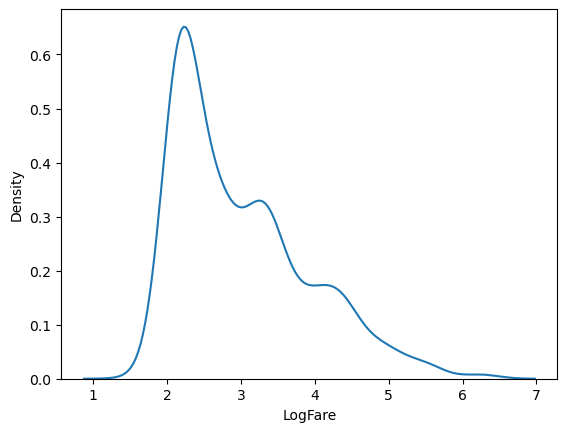

In [41]:
sns.kdeplot(data=df_fare, x='LogFare');

KDE plot stands for 'Kernel Density Estimate' plot. This plot is a histogram that approximates the discrete histogram as a continuous probability density function. The approximation is made by passing over the discrete histogram with a Gaussian kernel. In this plot, the y-axis "Density" is the sum of the parametric distributions produced by the Gaussian kernel at each point (give some parameters for mean and stdev).

Recall that the Normal PDF, or "Gaussian Function" is:
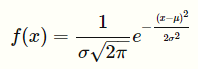

**Important Point:** The observation must be the mean of the Gaussian. To model the Gaussian distribution around that mean, we pick an *arbitrary* range of values that the observation lies within and fit that range to the distribution. This range doesn't matter, it just must include the observations that we want to estimate for. However, if the range matches the range that we wish to plot, then the plots will be distorted because the distributions would be fit with means that are at the extremes of the range (e.g., obs=10, range= [1, 10], cannot be fit with a normal distribution because there are no elements of the range above 10)

In [49]:
x_rng = np.linspace(0, 20, 100)[:, None]

In [50]:
def gaussian(stdev, obs):
    y = np.exp((-obs**2) / (2*stdev**2)) / (stdev * (2*np.pi)**0.5)
    return y

In [51]:
obs = np.random.randint(10, size=5)
obs

array([7, 1, 3, 2, 6])

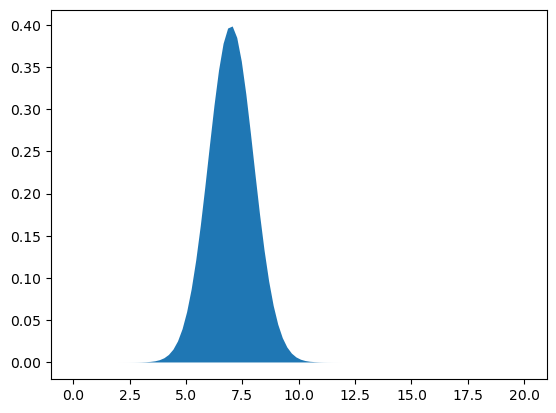

In [52]:
plt.fill(x_rng, gaussian(1,x_rng-obs[0]))

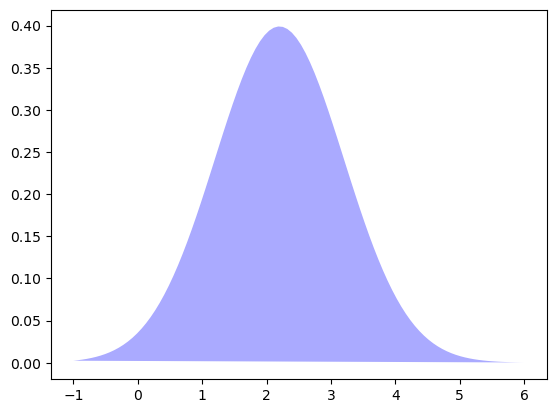

In [46]:
X=np.array([2.2])
X_plot = np.linspace(-1, 6, 100)[:, None]
plt.fill(X_plot, gaussian(1,X_plot-X[0]), '-k', fc='#AAAAFF')

The formal formula for a kernel density estimator is:
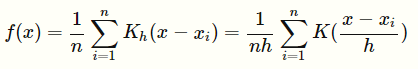
Where *n* is the number of data points, *h* is a smoothing parameter (bandwidth), and *K* is the kernel function. We are using the Gaussian PDF as our kernel function.

**Note:** The bandwidth parameter is also used to replace the stdev parameter in the kernel function!

In [47]:
def gaussian_kde(b, obs, rng):
    n = len(obs)
    y = sum(gaussian(b, rng - x) for x in obs) / n
    return y        

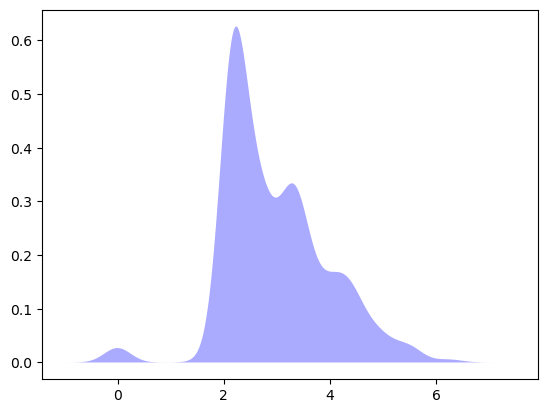

In [48]:
rng = np.linspace(-1, max(df['LogFare'])*1.2, len(df['LogFare']))
kde_logfare = gaussian_kde(b=0.25, obs=df['LogFare'], rng=rng)

plt.fill(rng, kde_logfare, '-k', fc='#AAAAFF');

So, it looks like we're approximating the seaborn KDE plot, nice.

Credit to these resources:
- https://www.homeworkhelponline.net/blog/math/tutorial-kde
- https://rstudio-pubs-static.s3.amazonaws.com/515412_68b7f95927114cd4aabc85d519adad1a.html